# Surface Temperature Exploration and Forecast

***

## Contents
1. [Overview](#overview)
2. [Data Exploration](#exploration)
3. [Forecasting-ARIMA](#arima)
4. [Forecasting-LSTM](#lstm)
5. [Conclusion](#conclusion)

***

<a id= 'overview'></a>
### 1. *Overview*
In this notebook we will be looking at changes in surface temperature of areas around the world from 1961-2020 using the dataset found on the [website](http://www.fao.org/faostat/en/#data/ET) of the Food and Agriculture Organization of the United Nations. The changes in temperature are with reference to a baseline climatology found within the reference period of 1951-1980. Thereafter, we will attempt to forecast temperature changes using two popular techniques.

***

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import seaborn as sns
from matplotlib.collections import LineCollection
%matplotlib inline


from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.tseries.offsets import DateOffset
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

<a id= 'exploration'></a>
***

### 2. *Data Exploration*
In this section we will use some simple questions to provide guidance in our exploration.
1.  [Is global warming present? If so, is it a recent phenomenon?](#2.1)
2.  [Do different regions on Earth warm equally?](#2.2)
3.  [Is global warming seasonal?](#2.3)

In [2]:
# Importing data
df = pd.read_csv('Environment_Temperature_change_E_All_Data_NOFLAG.csv')
df.head()

,Area Code,Area,Months Code,Months,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Y2018,Y2019
0,2,Afghanistan,7001,January,7271,Temperature change,�C,0.777,0.062,2.744,...,3.601,1.179,-0.583,1.233,1.755,1.943,3.416,1.201,1.996,2.951
1,2,Afghanistan,7001,January,6078,Standard Deviation,�C,1.950,1.950,1.950,...,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950
2,2,Afghanistan,7002,February,7271,Temperature change,�C,-1.743,2.465,3.919,...,1.212,0.321,-3.201,1.494,-3.187,2.699,2.251,-0.323,2.705,0.086
3,2,Afghanistan,7002,February,6078,Standard Deviation,�C,2.597,2.597,2.597,...,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597
4,2,Afghanistan,7003,March,7271,Temperature change,�C,0.516,1.336,0.403,...,3.390,0.748,-0.527,2.246,-0.076,-0.497,2.296,0.834,4.418,0.234


In [3]:
# Remove columns that are not needed
df.drop(['Area Code','Months Code','Element Code','Unit'], axis = 1, inplace = True)

# Keep rows containing temperature change data
df = df[df.Element == 'Temperature change']

# List of months and continents for exploration
month = ['January','February','March','April','May','June','July','August','September','October','November','December']
continents = ['Africa','Asia','Europe','Northern America','South America','Australia','Antarctica','World']



# Separate data into yearly, seasonal, and monthly data
df_month = df[df.Months.isin(month)]
df_month = df_month.loc[df_month.Area.isin(continents)]

df_year = df[df.Months == 'Meteorological year']
df_year = df_year.loc[df_year.Area.isin(continents)]

df_season = df[(~df.index.isin(df_month.index))&(~df.index.isin(df_year.index))]
df_season = df_season.loc[df_season.Area.isin(continents)]

# Transform dataframes into a more user-friendly format
def clean_df(df):
    df = df.transpose()
    df.columns = df.iloc[0]
    df.reset_index(inplace = True)
    df.drop(labels = [0,2], axis = 0, inplace = True)
    return df

df_month = clean_df(df_month)
df_year = clean_df(df_year)
df_season = clean_df(df_season)

df_year.head()

Area,index,Antarctica,Australia,World,Africa,Northern America,South America,Asia,Europe
1,Months,Meteorological year,Meteorological year,Meteorological year,Meteorological year,Meteorological year,Meteorological year,Meteorological year,Meteorological year
3,Y1961,0.28,0.151,0.207,-0.017,0.017,0.116,0.049,0.874
4,Y1962,-0.227,0.123,0.034,-0.04,-0.058,-0.139,-0.008,0.3
5,Y1963,0.135,-0.114,0.159,0.064,0.372,0.139,0.266,0.103
6,Y1964,-0.366,-0.022,-0.253,-0.153,-0.285,-0.217,-0.166,-0.523


<a id = '2.1'></a>
#### 2.1 Is global warming present? If so, is it a recent phenomenon
In this section we will analyse the yearly changes in temperature to find out if Earth is heating up and if so, when did it start?

Text(0.5, 1.0, 'Change in Temp since baseline')

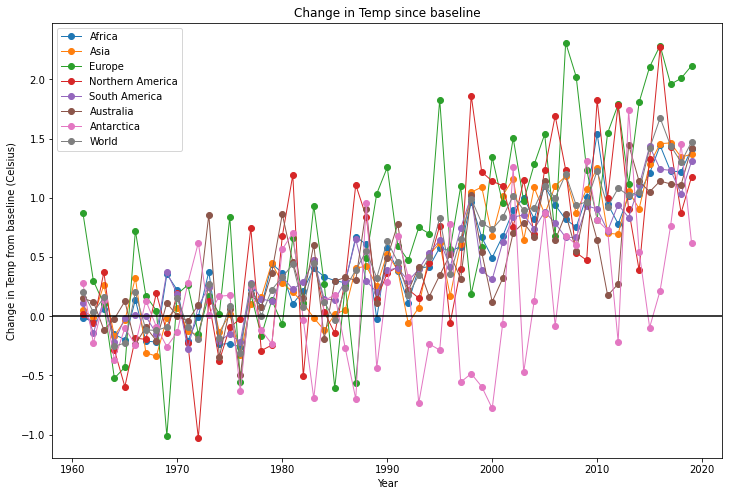

In [4]:
# Plotting the temperature changes of seven different continents and the World
fig, ax = plt.subplots(figsize = (12,8))
for i in continents:
    ax.plot(list(range(1961,2020)), df_year[i][1:], marker = 'o', lw = 1, label = str(i))
ax.legend()
ax.axhline(0, 0, 1, linewidth = 1.5, color = 'black') # except Antartica, every continent has not experienced cooler temps compared to baseline since 1990s
ax.set(xlabel = 'Year', ylabel = 'Change in Temp from baseline (Celsius)')
ax.set_title('Change in Temp since baseline')

Looking at the plot above, it is apparent that all areas on Earth are experiencing an upwards trend in surface temperature within this dataset encompassing the years 1961-2020. Except Antartica, every continent has not experienced cooler temps compared to baseline since 1990s. Next, we shall focus on temperature changes for Earth as a whole to find out when did the warming start.<br><br>
We shall define temperature changes within the interquartile range of the dataset as 'normal fluctuations', while temperature changes falling within the lower or upper quantiles will signify larger temperature swings that are not normally observed.

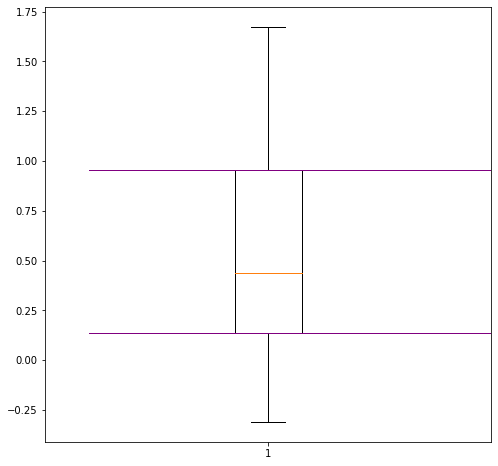

In [5]:
# Boxplot for temperature changes of the World
fig, ax = plt.subplots(figsize = (8,8))
ax.boxplot(df_year['World'][1:])
# purple lines covers the interquartile range
ax.axhline(df_year.World[1:].quantile(q = 0.75), 0.1, linewidth = 1, color = 'purple') 
ax.axhline(df_year.World[1:].quantile(q = 0.25), 0.1, linewidth = 1, color = 'purple')

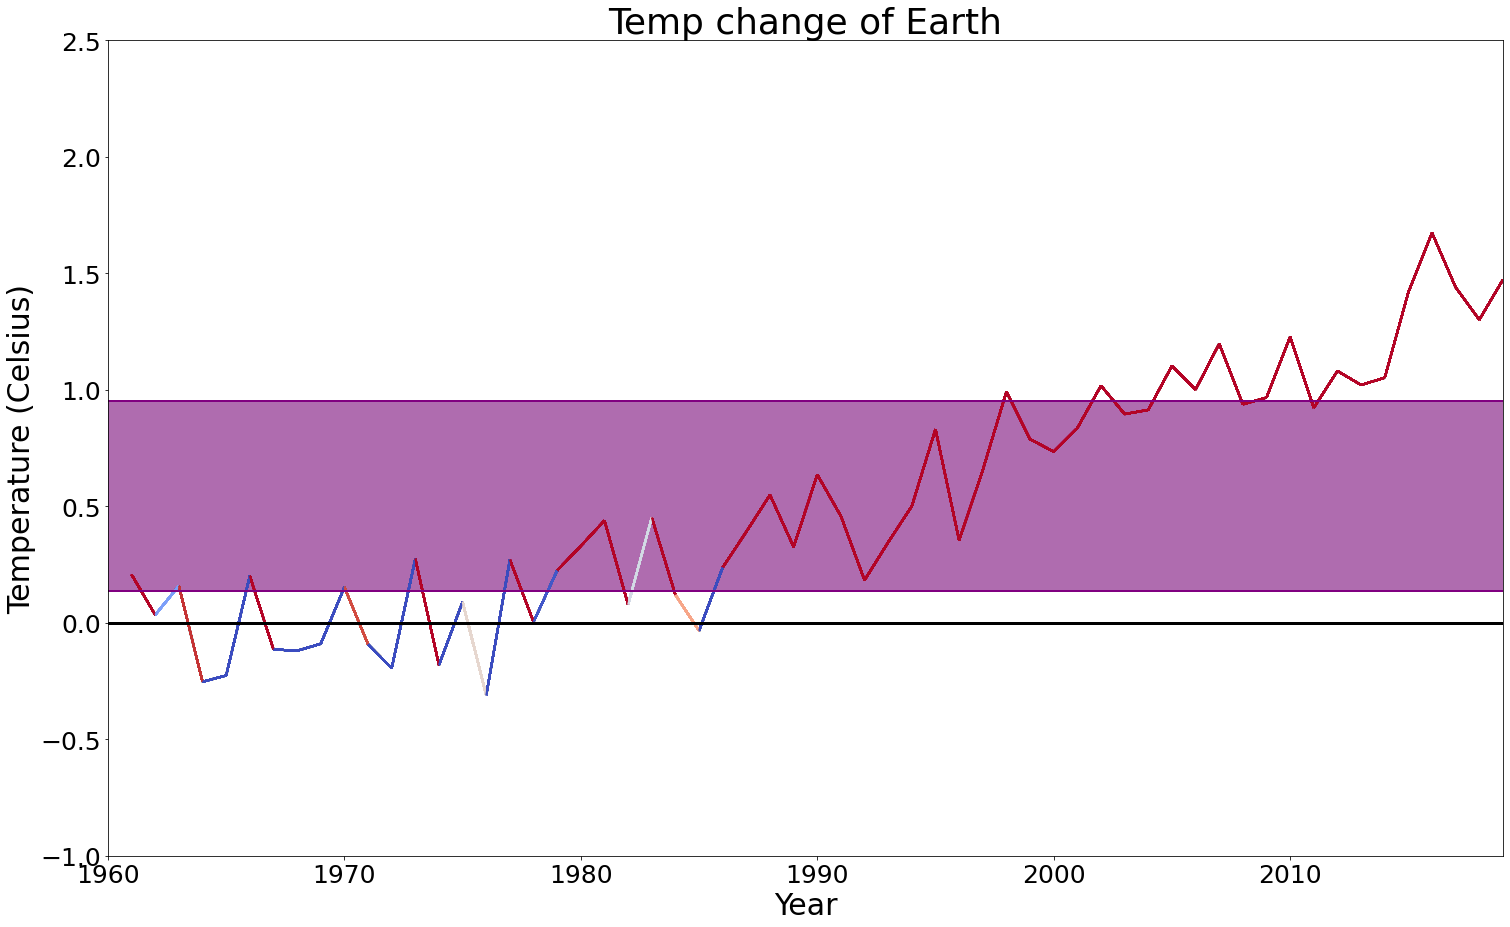

In [6]:
            # animate warming
fig2 = plt.figure(figsize = (25,15))
ax = plt.axes()
x, y = [], []
line, = ax.plot(0, 0, alpha = 0)

            # create cmap for animation
warming_cmap = plt.cm.get_cmap('coolwarm')
colors = []
for i in range(1,60):
    colors.append(warming_cmap(10*df_year.World.iloc[i]/max(df_year.World.iloc[1:])))

            # map color to corresponding data    
segments = []
for x1,x2,y1,y2 in zip(range(1961,2020),range(1962,2020), df_year.World.iloc[1:], df_year.World.iloc[2:]):
    segments.append([(x1,y1),(x2,y2)])
lc = LineCollection(segments, colors = colors, linewidths = 2)

            # animate
def animate(i):
    ax.add_collection(lc)
    
    ax.set_xlim(1960, 1962+i)
    ax.set_ylim(-1,2.5)
    
    ax.set_title('Temp change of Earth', fontsize = 36)
    ax.tick_params(axis = 'x', labelsize = 25)
    ax.tick_params(axis = 'y', labelsize = 25)
    ax.set_ylabel('Temperature (Celsius)',fontsize=30)
    ax.set_xlabel('Year',fontsize=30)
    
    x.append(i+1960)
    y.append(df_year.World.iloc[i+1])
    line.set_xdata(x)
    line.set_ydata(y)
    
    ax.axhline(df_year.World[1:].quantile(q = 0.75), linewidth = 2, color = 'purple')
    ax.axhline(df_year.World[1:].quantile(q = 0.25), linewidth = 2, color = 'purple')
    ax.axhspan(df_year.World[1:].quantile(q = 0.25), df_year.World[1:].quantile(q = 0.75), facecolor = 'purple', alpha = 0.01)
    
    ax.axhline(0, 0, 1, linewidth = 3, color = 'black')
    return line,

animatedplot = FuncAnimation(fig2, animate, frames = 58, repeat_delay = 1e2, blit = False, repeat = False)

animatedplot.save('WorldTemp.gif', writer = 'pillow', fps = 5)

From the plot we observe that between 1961 to 1980 the temperature fluctuated around the 0 degree line before the uptrend started around 1980, suggesting that global warming is not a very recent phenomenon and has begun since at least the 1980s. A limitation of this analysis is the relatively short time period that this dataset encompasses, and the one dimensional nature of the dataset. Without looking at a longer period of Earth's climate patterns, we cannot immediately rule out that the changes observed in the above plots are with the range of normal temperature fluctuations on Earth. By adding more dimensions to the data (ie. industrial activity over time, greenhouse gas emission data, etc) a more concrete conclusion on whether the recent warming of Earth is 'normal'.

***

<a id='2.2'></a>
#### 2.2 Do different regions of Earth warm equally?
Violin plots will be used to observed the temperature changes of different continents within the given time period.

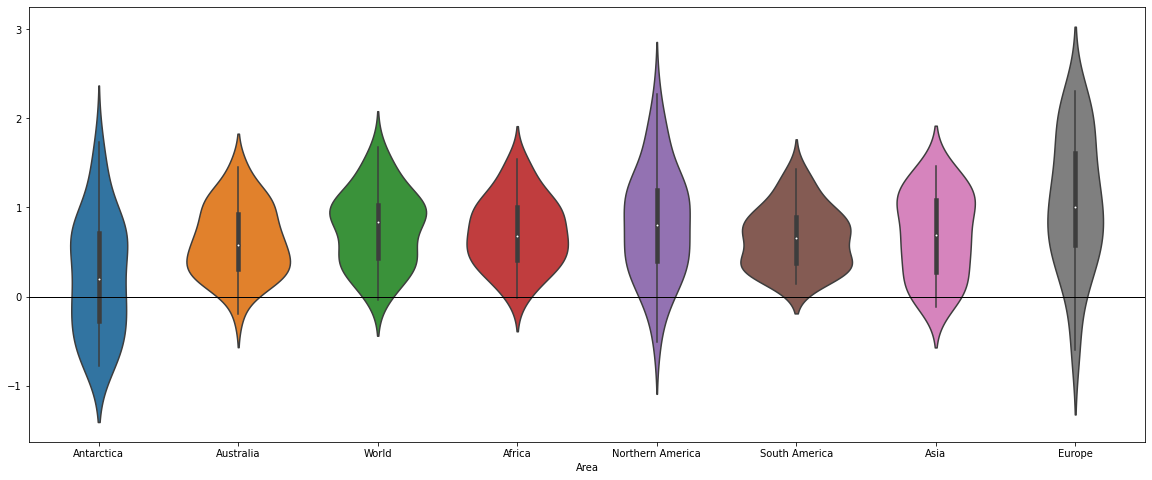

In [7]:
# Violin plot
fig, ax = plt.subplots(figsize = (20,8))
sns.violinplot(ax = ax, data = df_year.iloc[20:,1:])
ax.axhline(0, 0, 1, linewidth = 1, color = 'black')

The violin plots show that Antartica, North America and Europe experienced the most extreme temperature changes since 1980, with all continents experiencing a median positive increase in temperature from baseline. This suggests that temperature changes across Earth is not equal.

***

<a id='2.3'></a>
#### 2.3 Is global warming seasonal?
Next, we will explore seasonality of temperature changes by looking at data from Australia and North America which have significantly different violin plots in section 2.2.

Text(0.5, 1.0, 'Seasonal Temp changes in Australia (Celsius)')

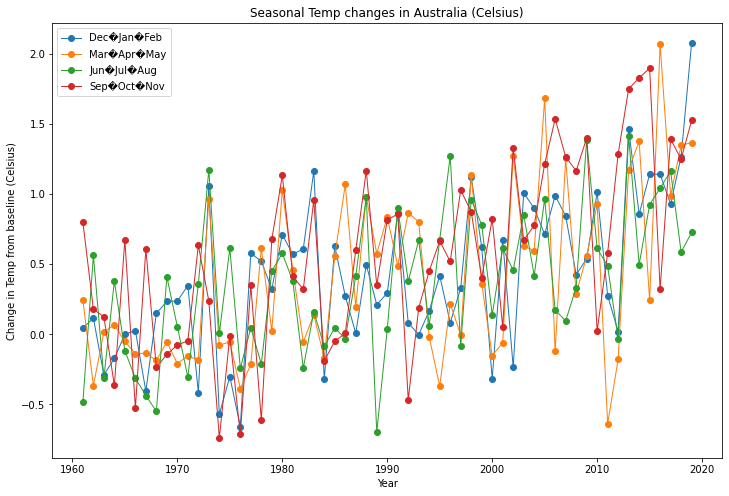

In [8]:
# Australia
    # line plot
df_aus = df_season['Australia']
df_aus.columns = df_aus.iloc[0]
df_aus = df_aus.iloc[1:]

fig, ax = plt.subplots(figsize = (12,8))
for i in range(0,4):
    ax.plot(list(range(1961,2020)), df_aus.iloc[:, i], marker = 'o', lw = 1, label = str(df_aus.columns[i]))
ax.legend()
ax.set(xlabel = 'Year', ylabel = 'Change in Temp from baseline (Celsius)')
ax.set_title('Seasonal Temp changes in Australia (Celsius)')

Plotting all four seasons together results in a figure that is difficult to read.

Text(0.5, 1.0, 'Seasonal Temp changes in Australia (Celsius)')

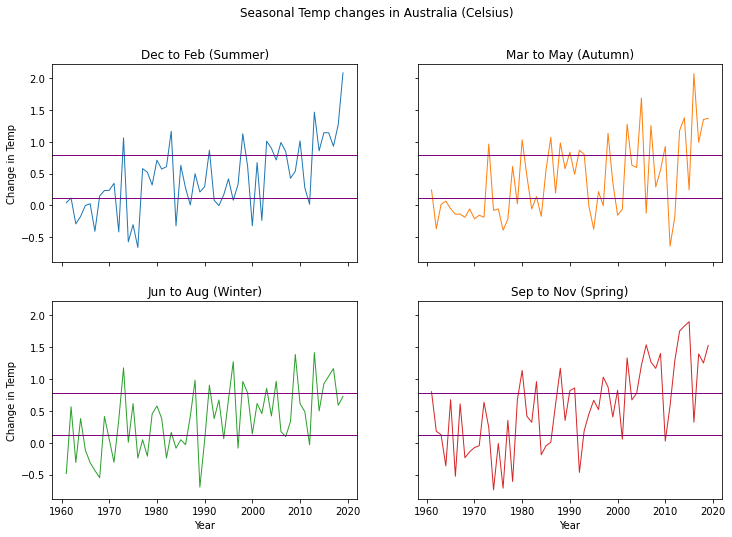

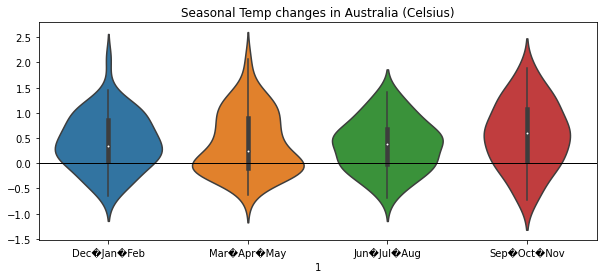

In [9]:
# 2x2 individual line plots
fig, axs = plt.subplots(2,2, sharex = True, sharey = True, figsize = (12,8))
axs[0,0].plot(list(range(1961,2020)), df_aus.iloc[:, 0], lw = 1, color = 'tab:blue')
axs[0,0].set_title('Dec to Feb (Summer)')
axs[0,0].axhline(df_year['Australia'][1:].quantile(q = 0.75), linewidth = 1, color = 'purple')
axs[0,0].axhline(df_year['Australia'][1:].quantile(q = 0.25), linewidth = 1, color = 'purple')

axs[0,1].plot(list(range(1961,2020)), df_aus.iloc[:, 1], lw = 1, color = 'tab:orange')
axs[0,1].axhline(df_year['Australia'][1:].quantile(q = 0.75), linewidth = 1, color = 'purple')
axs[0,1].axhline(df_year['Australia'][1:].quantile(q = 0.25), linewidth = 1, color = 'purple')
axs[0,1].set_title('Mar to May (Autumn)')

axs[1,0].plot(list(range(1961,2020)), df_aus.iloc[:, 2], lw = 1, color = 'tab:green')
axs[1,0].axhline(df_year['Australia'][1:].quantile(q = 0.75), linewidth = 1, color = 'purple')
axs[1,0].axhline(df_year['Australia'][1:].quantile(q = 0.25), linewidth = 1, color = 'purple')
axs[1,0].set_title('Jun to Aug (Winter)')

axs[1,1].plot(list(range(1961,2020)), df_aus.iloc[:, 3], lw = 1, color = 'tab:red')
axs[1,1].axhline(df_year['Australia'][1:].quantile(q = 0.75), linewidth = 1, color = 'purple')
axs[1,1].axhline(df_year['Australia'][1:].quantile(q = 0.25), linewidth = 1, color = 'purple')
axs[1,1].set_title('Sep to Nov (Spring)')

for ax in axs.flat:
    ax.set(xlabel = 'Year', ylabel = 'Change in Temp')
for ax in axs.flat:
    ax.label_outer()
fig.suptitle('Seasonal Temp changes in Australia (Celsius)')    

# violin plot
fig, ax = plt.subplots(figsize = (10,4))
sns.violinplot(ax = ax, data = df_aus)
ax.axhline(0, 0, 1, linewidth = 1, color = 'black') #summer, autumn, winter, spring
ax.set_title('Seasonal Temp changes in Australia (Celsius)')

Text(0.5, 1.0, 'Seasonal Temp changes in North America (Celsius)')

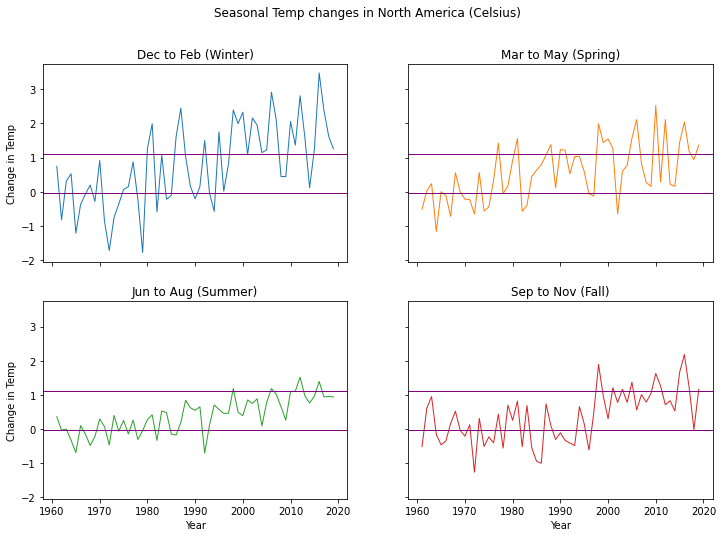

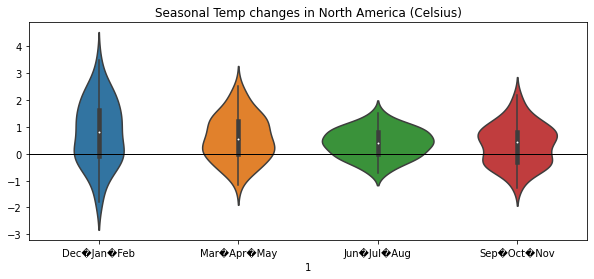

In [10]:
# North America
df_na = df_season['Northern America']
df_na.columns = df_na.iloc[0]
df_na = df_na.iloc[1:]

# 2x2 individual line plots
fig, axs = plt.subplots(2,2, sharex = True, sharey = True, figsize = (12,8))
axs[0,0].plot(list(range(1961,2020)), df_na.iloc[:, 0], lw = 1, color = 'tab:blue')
axs[0,0].set_title('Dec to Feb (Winter)')
axs[0,0].axhline(df_year['Northern America'][1:].quantile(q = 0.75), linewidth = 1, color = 'purple')
axs[0,0].axhline(df_year['Northern America'][1:].quantile(q = 0.25), linewidth = 1, color = 'purple')

axs[0,1].plot(list(range(1961,2020)), df_na.iloc[:, 1], lw = 1, color = 'tab:orange')
axs[0,1].axhline(df_year['Northern America'][1:].quantile(q = 0.75), linewidth = 1, color = 'purple')
axs[0,1].axhline(df_year['Northern America'][1:].quantile(q = 0.25), linewidth = 1, color = 'purple')
axs[0,1].set_title('Mar to May (Spring)')

axs[1,0].plot(list(range(1961,2020)), df_na.iloc[:, 2], lw = 1, color = 'tab:green')
axs[1,0].axhline(df_year['Northern America'][1:].quantile(q = 0.75), linewidth = 1, color = 'purple')
axs[1,0].axhline(df_year['Northern America'][1:].quantile(q = 0.25), linewidth = 1, color = 'purple')
axs[1,0].set_title('Jun to Aug (Summer)')

axs[1,1].plot(list(range(1961,2020)), df_na.iloc[:, 3], lw = 1, color = 'tab:red')
axs[1,1].axhline(df_year['Northern America'][1:].quantile(q = 0.75), linewidth = 1, color = 'purple')
axs[1,1].axhline(df_year['Northern America'][1:].quantile(q = 0.25), linewidth = 1, color = 'purple')
axs[1,1].set_title('Sep to Nov (Fall)')


for ax in axs.flat:
    ax.set(xlabel = 'Year', ylabel = 'Change in Temp')
for ax in axs.flat:
    ax.label_outer()
fig.suptitle('Seasonal Temp changes in North America (Celsius)') 


# violin plot
fig, ax = plt.subplots(figsize = (10,4))
sns.violinplot(ax = ax, data = df_na)
ax.axhline(0, 0, 1, linewidth = 1, color = 'black') #winter, spring, summer, fall
ax.set_title('Seasonal Temp changes in North America (Celsius)')

Looking at Australia's temperature changes across seasons we observe that winter typically has the least change in temperature from year to year. On the other hand, North America experiences the largest temperature swings during Winter while temperature changes during summer is smaller than the rest of the year. This suggests that seasonality is present in temperature change on Earth. In addition to what was shown in section 2.2, this further illustrates the difference in how different regions on Earth experiences temperature changes.

***

<a id = 'arima'></a>
### 3. *Forecasting - ARIMA*
In this section we will attempt to forecast monthly temperature changes on Earth using **AutoRegressive Intergrated Moving Average [ARIMA]**. This type of model is one of the most popular choices for time series analysis.
<br><br>
A few parameters will have to be determined to begin with, namely:
* **p**: The number of lag observations the model will use
* **d**: The number of times that the raw observations are differenced before stationarity
* **q**: The size of the moving average window

Additionally, since we are working on seasonal data we will require:
* **P**: The number of seasonal lag observations the model will use
* **D**: The number of times that the seasonal observations are differenced before stationarity
* **Q**: The size of the seasonal moving average window
* **m**: The number of observations in one season

<br><br>
First we will prepare the data for analysis before looking for the **d** and **D** parameters first.

In [11]:
# Prepare monthly data for use in analysis
temp = df_month[['index','World']][1:]

temp_1, temp_2 = [], [] # temp_1 will contain time data (YYYY-MM-DD), temp_2 will contain temperature changes
k = 0
for i in temp['index']:
    for j in range(12):
        temp_1.append(str(i) + '-'+str(j+1))
        temp_2.append(temp.iloc[k,j+1])
    k+=1
    
temp_1 = [i.strip('Y') for i in temp_1]
forecast_world = pd.DataFrame(data = {'date':temp_1, 'World':temp_2})
forecast_world['date'] = pd.to_datetime(forecast_world['date'])
forecast_world = forecast_world.set_index('date')
forecast_world = forecast_world.asfreq('MS')
forecast_world.head()

,World
date,
1961-01-01,0.399
1961-02-01,0.263
1961-03-01,0.254
1961-04-01,0.278
1961-05-01,0.367


In [12]:
# Test for stationarity using Augmented Dickey-Fuller Test
result=adfuller(forecast_world['World'])
test_dict = (dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'],result))) 
if test_dict['pvalue'] >= 0.05:
    print('p-value is above 0.05, data not stationary')
else:
    print('p-value is below 0.05, data is stationary')

p-value is above 0.05, data not stationary


In [13]:
# Differencing to transform non-stationary to stationary
forecast_world['1diff'] = forecast_world['World'] - forecast_world['World'].shift(1)
result = adfuller(forecast_world['1diff'].dropna())
test_dict = (dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'],result))) 
if test_dict['pvalue'] >= 0.05:
    print('p-value is above 0.05, data not stationary')
else:
    print('p-value is below 0.05, data is stationary')

p-value is below 0.05, data is stationary


In this case we had to difference the data one time before it becomes stationary, which means that our **d** parameter for ARIMA will be 1.

In [14]:
# Test seasonal difference for stationarity
forecast_world['seasonal'] = forecast_world['World'] - forecast_world['World'].shift(12) # shift by 12 as one season(a year) is 12 observations
result = adfuller(forecast_world['seasonal'].dropna())
test_dict = (dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'],result))) # pvalue < 0.05, stationary, D = 0
if test_dict['pvalue'] >= 0.05:
    print('p-value is above 0.05, data not stationary')
else:
    print('p-value is below 0.05, data is stationary')

p-value is below 0.05, data is stationary


We obtain 0 for **D** parameter as the seasonal data is already stationary before any further differencing. Next we will look for the **p**,**q**,**P**, and **Q** parameters with reference to rules for [ARIMA](https://people.duke.edu/~rnau/arimrule.htm) and [Seasonal ARIMA](https://people.duke.edu/~rnau/seasarim.htm).

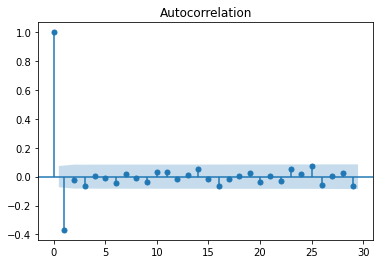

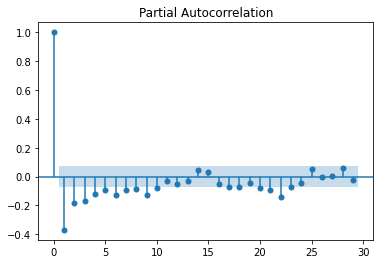

In [15]:
# Autocorrelation and Partial Autocorrelation Plots for non-seasonal data
fig1 = plot_acf(forecast_world['1diff'].dropna())
fig2 = plot_pacf(forecast_world['1diff'].dropna())

Since both the autocorrelation and the partial autocorrelation plots experienced sharp cut-offs at lag-1, the chosen **p** and **q** parameters are both 1.

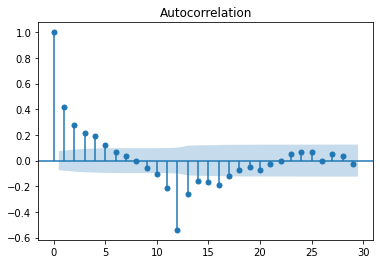

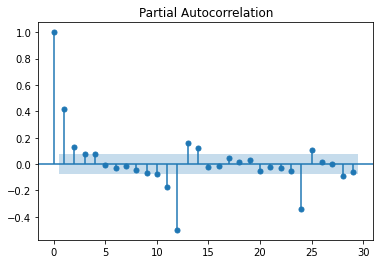

In [16]:
# Autocorrelation and Partial Autocorrelation Plots for seasonal data
fig3 = plot_acf(forecast_world['seasonal'].dropna()) 
fig4 = plot_pacf(forecast_world['seasonal'].dropna()) 

As the autocorrelation at the seasonal period is negative, we shall add a seasonal moving average term (**Q** parameter) while leaving the seasonal autoregressive term (**P** parameter) as 0.<br><br>
Next we will fit the model using the parameters we have determined and forecast the monthly temperature for the next four years after the dataset ends.

<AxesSubplot:title={'center':'Monthly Temp Forecast up to December 2023'}>

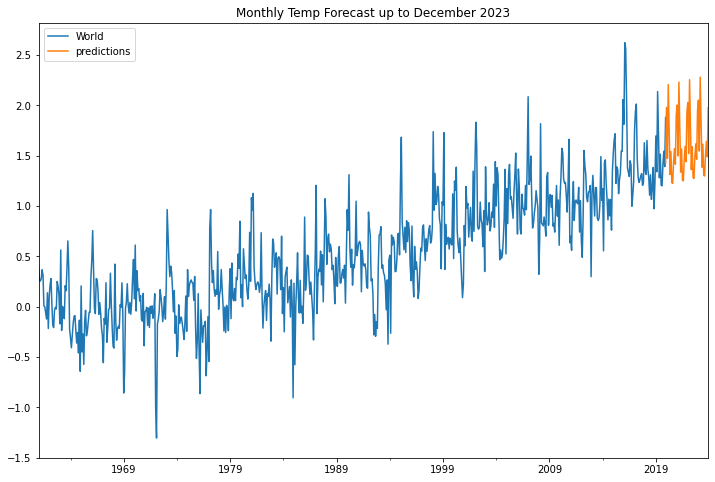

In [17]:
# Seasonal ARIMA model
model = SARIMAX(forecast_world['World'], order = (1,1,1), seasonal_order = (0,1,0,12)) #order = pdq, seasonal = PDQm
result = model.fit()

# Forecasting
new_dates = [forecast_world.index[-1]+DateOffset(months = x) for x in range(1,49)]
forecast_world_pred = pd.DataFrame(index = new_dates, columns = forecast_world.columns)
forecast_combined = pd.concat([forecast_world, forecast_world_pred])
forecast_combined['predictions'] = np.nan

forecast_combined['predictions'] = result.predict(start = 707, end = 755)
forecast_combined[['World', 'predictions']].plot(figsize = (12,8), title = 'Monthly Temp Forecast up to December 2023')

From the forecast we are able to clearly see that the model picks up the upward trend in temperature that has been present for decades, and seasonal nature of temperature changes. Alternatively, we can fit the model on data from before 2016, and forecast the temperature predictions up to 2020 to give a comparison between the predicted and actual temperatures in those four years.

<AxesSubplot:title={'center':'Monthly Temp Forecast between 2016 and 2020'}, xlabel='date'>

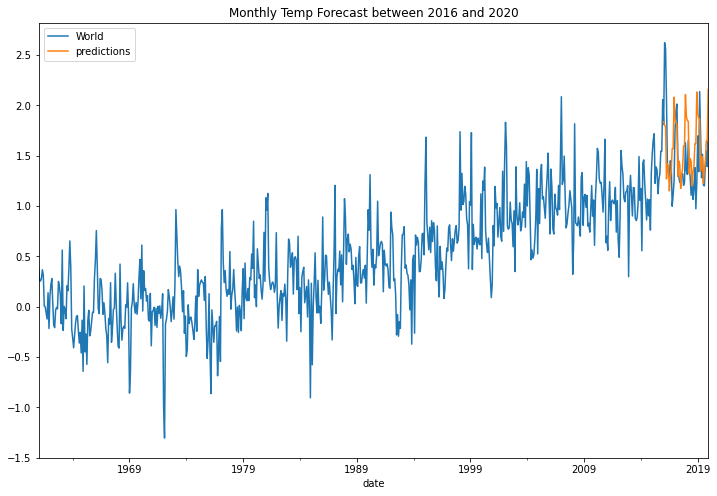

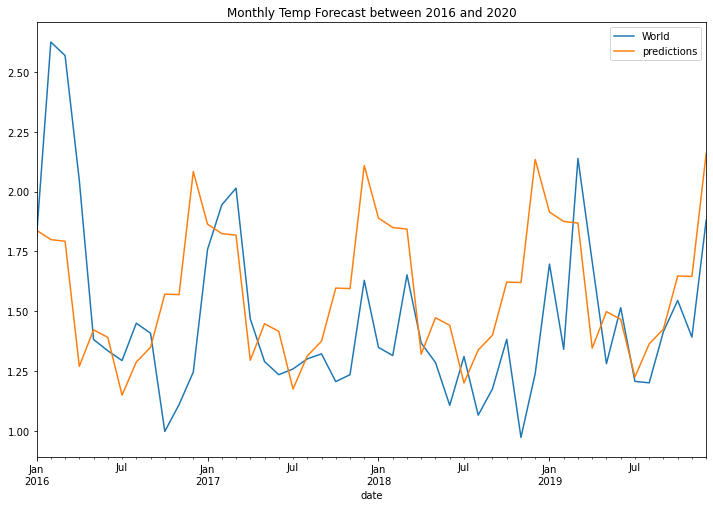

In [18]:
# Alternative view by validation
alt = forecast_world.copy()
alt['validate'] = alt['World'].iloc[:660]
model_val = SARIMAX(alt['validate'], order = (1,1,1), seasonal_order = (0,1,0,12))
result_val = model_val.fit()
alt['predictions'] = result_val.predict(start = 660, end = 707)
alt[['World','predictions']].plot(figsize = (12,8), title = 'Monthly Temp Forecast between 2016 and 2020')
alt[['World','predictions']].iloc[660:].plot(figsize = (12,8), title = 'Monthly Temp Forecast between 2016 and 2020')

Similarly, from the first plot we observe in the forecasts the upward trend that is present in the dataset. In the second plot however, even though the forecasts has captured the general pattern of seasonality in temperature changes, the forecasted temperature peaks for these 4 years are slightly off the mark, arriving approximately 3 months earlier than the actual peaks in years 2017 and 2019.

***

<a id='lstm'></a>
### 4. *Forecasting - LSTM*
An alternative to ARIMA in forecasting time series data is with the use of **long short-term memory (LSTM)**, an artificial recurrent neural network architecture. Similarly, we will fit a model to forecast temperature changes for the latest 4 years in our dataset.

In [19]:

# Split data into training and test set
df_lstm = forecast_world.copy()
training_set = df_lstm.iloc[:660, 0].values.reshape(-1,1)
test_set = df_lstm.iloc[660:, 0].values.reshape(-1,1)


# Data structure with 60 time-steps and 1 output
x_train, y_train = [], []
for i in range(84,660):
    x_train.append(training_set[i-84:i, 0])
    y_train.append(training_set[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)

# At each time step with n-sized window of training/test data, normalize so that 
# at i=0 data point is 0  and data points reflect % changes
x_norm = x_train.copy()
y_norm = y_train.copy()

for i in range(x_norm.shape[0]):
    y_norm[i] = (y_train[i]/x_train[i,0])-1
    for j in range(x_norm.shape[1]):
        if x_train[i,0] == 0: # if value of data point at i=0 before normalization is 0, use previous data point
            x_norm[i,j] = (x_train[i,j]/x_train[i-1,0])-1
            y_norm[i] = (y_train[i]/x_train[i-1,0])-1
        else:
            x_norm[i,j] = (x_train[i,j]/x_train[i,0])-1

x_norm = np.reshape(x_norm, (x_norm.shape[0], x_norm.shape[1], 1))


# LSTM Model
''''
model = Sequential()

model.add(LSTM(units = 4, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 2, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 2))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

opt = keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer = opt, loss = 'mean_absolute_error')

model.fit(x_norm, y_norm, epochs = 100, batch_size = 9)
'''
model = keras.models.load_model('lstm_temp')

<ipython-input-19-a9bac082f9a3>:20: RuntimeWarning: divide by zero encountered in double_scalars
  y_norm[i] = (y_train[i]/x_train[i,0])-1


Text(0.5, 1.0, 'Monthly')

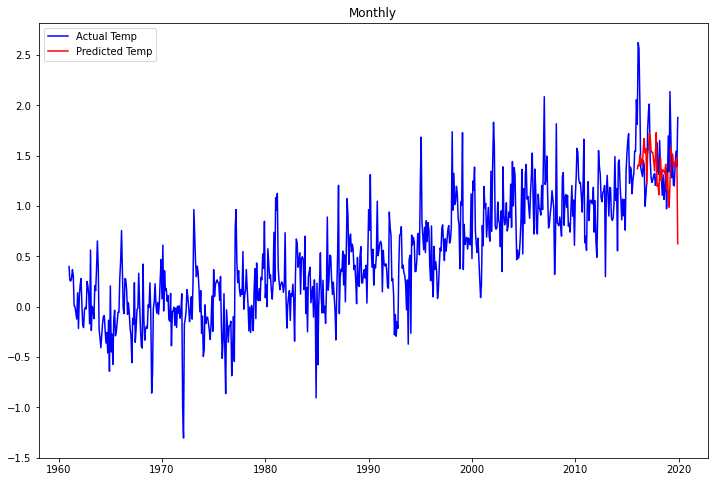

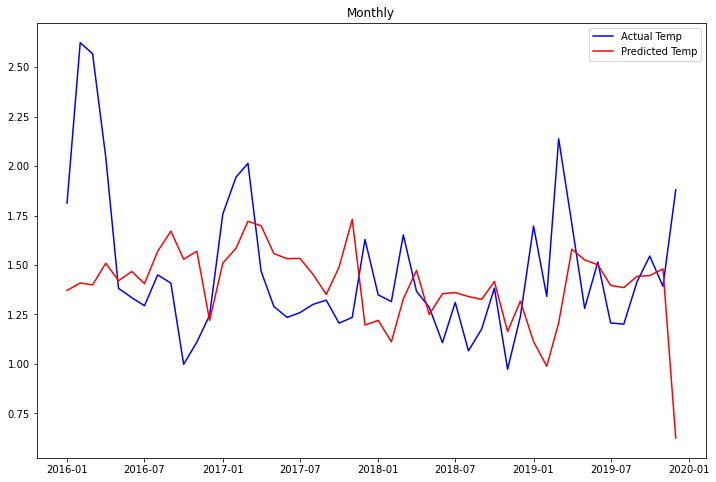

In [36]:
# Prepare test data
df_train = df_lstm.iloc[:660, 0]
df_test = df_lstm.iloc[660:, 0]
df_total = pd.concat((df_train, df_test), axis = 0)

inputs = df_total[len(df_total)- len(df_test) - 84:].values.reshape(-1, 1)

x_test = []
for i in range(84,132):
    x_test.append(inputs[i-84:i, 0])
x_test = np.array(x_test)

x_norm_test = x_test.copy()
for i in range(x_norm_test.shape[0]):
    for j in range(x_norm_test.shape[1]):
        if x_test[i,0] == 0:
            x_norm_test[i,j] = (x_test[i,j]/x_test[i-1,0])-1
        else:
            x_norm_test[i,j] = (x_test[i,j]/x_test[i,0])-1
        
x_norm_test = np.reshape(x_norm_test, (x_norm_test.shape[0], x_norm_test.shape[1], 1))

# Validate
prediction = model.predict(x_norm_test)
y_denorm = prediction.copy()
for i in range(x_norm_test.shape[0]):
    y_denorm[i] = x_test[i,0]*(prediction[i] + 1)

# Plotting results
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(df_lstm.index[:], df_lstm.World[:], color = 'blue', label = 'Actual Temp')
ax.plot(df_lstm.index[660:], y_denorm, color = 'red', label = 'Predicted Temp')
ax.legend()
ax.set_title('Monthly')

fig2, ax2 = plt.subplots(figsize = (12,8))
ax2.plot(df_lstm.index[660:], df_lstm.World[660:], color = 'blue', label = 'Actual Temp')
ax2.plot(df_lstm.index[660:], y_denorm, color = 'red', label = 'Predicted Temp')
ax2.legend()
ax2.set_title('Monthly')

The LSTM model seems to be able to correctly predict the direction of most temperature changes in the test dataset, with the obvious exception at the start and end of the test data, where sharp temperature spikes are not forecasted by the model at all. <br><br>
Looking at the predictions by the two models, it is hard to tell which model is the better of the two. ARIMA was able to simply forecast a seasonal pattern that loosely fits with the observed reality, while LSTM was able to predict the direction and magnitude of temperature changes relatively accurately without the obvious repeating seasonal patterns. To give a more objective comparison, we shall use root mean squared error to compare the accuracy of their respective predictions.

In [40]:
# RMSE for ARIMA model
err_ARIMA = rmse(alt['World'].iloc[660:],alt['predictions'].iloc[660:])
print('RMSE with ARIMA: ', err_ARIMA)

# RMSE for LSTM model
err_LSTM = rmse(df_lstm['World'].iloc[660:],y_denorm[:,0])
print('RMSE with LSTM: ', err_LSTM)

RMSE with ARIMA:  0.3761797326012911
RMSE with LSTM:  0.42052293821429926


With the above metrics, ARIMA appears to be the better performer with an RMSE of 0.376 vs LSTM's 0.420. To improve the performance of the LSTM model, the model can be trained on data over a larger time period with a larger time window at each training step, or the dimensionality of the dataset can be increased.

***

<a id ='conclusion'></a>
### 5. *Conclusion*
In this notebook we have explored surface mean air temperature data over the period of 1961-2020, answering several questions regarding the temperature change on Earth over this period, and built models using two different methods to forecast temperature changes in this time series data.